In [72]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[0]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

plt.rcParams.update({"font.size": 11})


In [73]:
def fetch_tc_fit_params(db_path, selected_construct, selected_site_base, selected_valtype_tc = 'modrate'):
    """
    Fetch fitted time-course parameters for a specific rg_id, site_base, and valtype.
    
    Parameters
    ----------
    db_path : str
        Path to the SQLite database file.
    selected_construct : str
        Construct disp_name
    selected_site_base : str
        Site and base combination (e.g., '18_A', '25_C').
    selected_valtype_tc : str
        Value type for filtering (e.g., 'modrate').

    Returns
    -------
    pd.DataFrame
        DataFrame containing fitted parameters with columns: fit_run_id, log_kobs,
        log_kdeg, log_fmod0, kobs, kdeg, fmod0, log_kobs_err, log_kdeg_err,
        log_fmod0_err, diag_r2.
    """

    conn = sqlite3.connect(db_path)
    fitted_params_df = pd.read_sql_query(
        """
        WITH run AS (
            SELECT id AS fit_run_id, rg_id
            FROM probe_tc_fit_runs
            WHERE (rg_id, nt_id) IN (
                SELECT DISTINCT pr.rg_id, mn.id
                FROM probe_reactions pr
                JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
                JOIN meta_nucleotides mn ON mn.id = fv.nt_id
                JOIN meta_constructs mc ON mc.id = pr.construct_id
                WHERE mc.disp_name = :selected_construct
                AND mn.site || '_' || UPPER(mn.base) = :site_base
            )
            AND fit_kind = 'round3_constrained'
            AND valtype = :valtype_mod
        )
        SELECT
            p.fit_run_id,
            r.rg_id,
            pr.temperature,
            pr.replicate,
            MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')
                    THEN p.param_numeric END) AS log_kappa,
            MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                    THEN p.param_numeric END) AS log_kdeg,
            MAX(CASE WHEN p.param_name IN ('log_fmod0','logfmod0')
                    THEN p.param_numeric END) AS log_fmod0,
            MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')
                    THEN p.param_numeric END) AS log_kappa_err,
            MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                    THEN p.param_numeric END) AS log_kdeg_err,
            MAX(CASE WHEN p.param_name IN ('log_fmod0_err','logfmod0_err')
                    THEN p.param_numeric END) AS log_fmod0_err,
            MAX(CASE WHEN p.param_name = 'diag:r2'
                    THEN p.param_numeric END) AS r2
        FROM probe_tc_fit_params p
        JOIN run r
            ON r.fit_run_id = p.fit_run_id
        JOIN probe_reactions pr
            ON pr.rg_id = r.rg_id
        GROUP BY
            p.fit_run_id,
            r.rg_id,
            pr.temperature,
            pr.replicate
        ORDER BY
            pr.temperature ASC,
            pr.replicate ASC;
        """,
        conn,
        params={"selected_construct": selected_construct, "site_base": selected_site_base, "valtype_mod": selected_valtype_tc},
    )
    conn.close()
    return fitted_params_df

def fetch_global_kdeg(db_path, selected_rg_id):
    """
    Fetch fitted time-course parameters for a specific rg_id, site_base, and valtype.
    
    Parameters
    ----------
    db_path : str
        Path to the SQLite database file.
    selected_construct : str
        Construct disp_name
    selected_site_base : str
        Site and base combination (e.g., '18_A', '25_C').
    selected_valtype_tc : str
        Value type for filtering (e.g., 'modrate').

    Returns
    -------
    pd.DataFrame
        DataFrame containing fitted parameters with columns: fit_run_id, log_kobs,
        log_kdeg, log_fmod0, kobs, kdeg, fmod0, log_kobs_err, log_kdeg_err,
        log_fmod0_err, diag_r2.
    """

    conn = sqlite3.connect(db_path)
    global_fit_params_df = pd.read_sql_query(
        """
        SELECT
            MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                    THEN p.param_numeric END) AS log_kdeg,
            MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                    THEN p.param_numeric END) AS log_kdeg_err
        FROM probe_tc_fit_params p
        JOIN probe_tc_fit_runs r
            ON r.id = p.fit_run_id
        JOIN probe_reactions pr
            ON pr.rg_id = r.rg_id
        WHERE r.rg_id = :selected_rg_id
        AND r.fit_kind = 'round2_global'

        GROUP BY
            p.fit_run_id,
            r.rg_id,
            pr.temperature,
            pr.replicate
        HAVING
            log_kdeg IS NOT NULL
        ORDER BY
            pr.temperature ASC,
            pr.replicate ASC
        """,
        conn,
        params={"selected_rg_id": selected_rg_id},
    )
    conn.close()
    return global_fit_params_df

In [74]:
# Load kadd arrhenius params for fourU
arrhenius_kadd_df = pd.read_csv('../Figure2_ProbeKinetics/Add_Arrhenius/Arrhenius_fit_params_4U_AC.csv')

def get_kadd(arrhenius_kadd_df, group, temp_C):
    """Calculate kadd at a given temperature using Arrhenius parameters given in kcal/mol."""
    R = sc.R / sc.calorie / 1000  # Gas constant in kcal/(mol·K) - 0.001987
    T = temp_C + 273.15  # Convert to Kelvin
    row = arrhenius_kadd_df[arrhenius_kadd_df['group'] == group].iloc[0]
    A = np.exp(row['lnA'])
    Ea = row['ea']
    kadd = A * np.exp(-Ea / (R * T))
    return kadd

def get_lnkaddP0_slope_int(arrhenius_kadd_df, group, conc_DMS):
    """Get slope and intercept of ln(kadd) vs 1/T for a given group."""
    R = sc.R / sc.calorie / 1000  # Gas constant in kcal/(mol·K)
    row = arrhenius_kadd_df[arrhenius_kadd_df['group'] == group].iloc[0]
    slope = -row['ea'] / R  # in K
    intercept = row['lnA'] + np.log(conc_DMS)
    return slope, intercept

# Calculate kadd for melted_agg_A at 25C with concentration
conc_DMS = 0.015852692  # in M, 1.5% v/v
kadd_A = get_kadd(arrhenius_kadd_df, 'melted_agg_A', 25) * conc_DMS
kadd_C = get_kadd(arrhenius_kadd_df, 'melted_agg_C', 25) * conc_DMS

print(f'kadd_A at 25C: {kadd_A} M^-1 s^-1')
print(f'kadd_C at 25C: {kadd_C} M^-1 s^-1')

kadd_A_params = get_lnkaddP0_slope_int(arrhenius_kadd_df, 'melted_agg_A', conc_DMS)
kadd_C_params = get_lnkaddP0_slope_int(arrhenius_kadd_df, 'melted_agg_C', conc_DMS)

kadd_A at 25C: 4.135706316624389e-05 M^-1 s^-1
kadd_C at 25C: 7.215254958829348e-05 M^-1 s^-1


In [75]:
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

def safe_frac(invT, dH_fold, Tm, R=1.987e-3, clip_logK=50.0, eps=1e-12):
    """
    invT     : 1/T in K^-1  (your x)
    dH_fold  : kcal/mol
    Tm       : °C (as in your current code)
    R        : kcal/(mol·K)
    """

    invT = np.asarray(invT)

    # Convert Tm to Kelvin
    TmK = Tm + 273.15

    # logK1 = (dH/R) * (1/Tm - 1/T) = (dH/R) * (1/TmK - invT)
    logK1 = (dH_fold / R) * (1.0 / TmK - invT)

    # Clip to avoid huge exponents in the logistic
    logK1 = np.clip(logK1, -clip_logK, clip_logK)

    # Stable logistic: fracf = 1 / (1 + exp(-logK1))
    fracf = 1.0 / (1.0 + np.exp(-logK1))
    fracu = 1.0 - fracf

    # If you ever reintroduce logs, avoid exact 0 or 1
    fracf = np.clip(fracf, eps, 1.0 - eps)
    fracu = np.clip(fracu, eps, 1.0 - eps)

    return fracu, fracf

def melt_fit(x, upper_m, upper_b, lower_m, lower_b, dH_fold, Tm):
    # upper_m: slope of the unfolded state
    # upper_b: y-intercept of the unfolded state
    # lower_m: slope of the folded state
    # lower_b: y-intercept of the folded state
    # dH_fold: energy of the transition state
    # Tm: temperature of the transition state
    
    temp = 1 / x

    R = sc.R / sc.calorie / 1000  # Gas constant in kcal/(mol·K)

    fracu, fracf = safe_frac(x, dH_fold, Tm, R=R)
    basef = lower_m * x + lower_b
    baseu = upper_m * x + upper_b

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

def fit_meltcurve(x, y, kadd_params = None, init_params = None):
    # Make sure x is sorted

    # Guess top baseline
    model = LinearModel()
    params = model.guess(y.iloc[:3], x = x.iloc[:3])
    top_fit = model.fit(y.iloc[:3], params, x = x.iloc[:3])
    init_upper_m = top_fit.params['slope'].value
    init_upper_b = top_fit.params['intercept'].value

    # Guess bottom baseline
    params = model.guess(y.iloc[-3:], x = x.iloc[-3:])
    bot_fit = model.fit(y.iloc[-3:], params, x = x.iloc[-3:])
    init_lower_m = bot_fit.params['slope'].value
    init_lower_b = bot_fit.params['intercept'].value
    
    # Set initial params
    if init_params is not None:
        tm_max = init_params.get('Tm_max', tm_max)
        tm_min = init_params.get('Tm_min', tm_min)
        init_tm = init_params.get('Tm', tm)
        init_dH_fold = init_params.get('dH_fold', dH_fold)
    else:
        tm_max = 60
        tm_min = 0
        init_tm = 42
        init_dH_fold = -60 

    # Set up fit model
    melt_model = Model(melt_fit)
    melt_params = melt_model.make_params(upper_m = init_upper_m, upper_b = init_upper_b, lower_m = init_lower_m, lower_b = init_lower_b, dH_fold = init_dH_fold, Tm = init_tm)
    
    melt_params['Tm'].vary = True
    melt_params['Tm'].max = tm_max
    melt_params['Tm'].min = tm_min
    
    # Use kadd_params from Arrhenius fit if provided
    if kadd_params is not None:
        # lock to kadd_params
        kadd_slope, kadd_intercept = kadd_params
        melt_params['upper_m'].value = kadd_slope
        melt_params['upper_b'].value = kadd_intercept
        melt_params['upper_m'].vary = False
        melt_params['upper_b'].vary = False

    # Perform actual fit
    melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)

    return melt_result

In [76]:
def apply_2state(site, construct, lnkadd_params, db_path=NERD_SQLITE):

    # Fetch fit params (kobs, kdeg, etc.)
    fit_params_df = fetch_tc_fit_params(db_path, construct, site)

    # Filter QC and/or outliers
    fit_params_df = fit_params_df[fit_params_df['r2'] > 0.3]
    # # filter outliers (for 25_C A8C)
    fit_params_df = fit_params_df[~fit_params_df['rg_id'].isin([9, 10, 21, 32, 33])]

    # drop fit_run_id 24229 (for 8_C A8C)
    fit_params_df = fit_params_df[fit_params_df['fit_run_id'] != 24229]
    # Calculate 1/T, log_kobs, and log_kobs_err
    fit_params_df['1/T'] = 1 / (fit_params_df['temperature'] + 273.15)
    fit_params_df['log_kobs'] = fit_params_df['log_kappa'] + fit_params_df['log_kdeg']
    fit_params_df['log_kobs_err'] = np.sqrt(fit_params_df['log_kappa_err']**2 + fit_params_df['log_kdeg_err']**2)

    # Sort by 1/T
    fit_params_df = fit_params_df.sort_values(by='1/T')

    fit_result = fit_meltcurve(fit_params_df['1/T'], fit_params_df['log_kobs'], kadd_params = lnkadd_params)

    return fit_result, fit_params_df

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


,construct,site,tm,tm_err
0,4U_wt,7_A,33.435136,4.522344
1,4U_wt,8_A,37.247694,3.365114
2,4U_wt,9_C,36.986052,1.303665
3,4U_wt,15_A,35.201106,1.499750
4,4U_wt,16_A,35.783561,1.753447
5,4U_wt,22_A,36.216147,0.898242
6,4U_wt,25_C,34.292134,2.454541
7,4U_wt,26_A,35.263365,1.168271
8,4U_wt,29_A,35.871972,0.877362
9,4U_wt,34_A,29.389170,5.256895


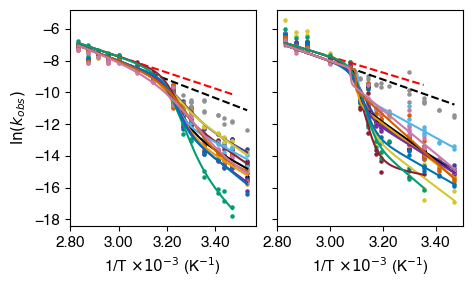

In [82]:
def calc_smoothed_best_fit(melt_result):
    x = melt_result.userkws['x']
    x_data = np.linspace(min(x), max(x), 1000)
    y_data = melt_result.eval(x = x_data)
    return x_data, y_data

to_fit = {'4U_wt': ['7_A', '8_A', '9_C', '15_A', '16_A', '18_A', '22_A', '25_C', '26_A', '29_A', '34_A', '35_A'],
          '4U_a8c': ['7_A', '8_C', '9_C', '15_A', '16_A', '18_A', '22_A', '25_C', '26_A', '29_A', '34_A', '35_A']}

site_palette = {'15_A': '#000000',
                '16_A': '#E69F00',
                '22_A': '#56B4E9',
                '25_C': '#009E73',
                '26_A': '#782AA8',
                '29_A': '#0072B2',
                '34_A': '#D55E00',
                '35_A': '#CC79A7',
                '7_A': '#403D99',
                '8_A': '#D4C72F',
                '8_C': '#D4C72F',
                '9_C': '#882233',
                '18_A': '#919191'}

kadd_params = {'A': kadd_A_params,
               'C': kadd_C_params}

# Store Tm's for barplot
rows = []
fig, axs = plt.subplots(1, 2, figsize = (5, 3), sharey = True)

for construct, sites in to_fit.items():
    if construct == '4U_wt':
        ax = axs[0]
        ax.set_ylabel(r'$\ln(k_{obs})$')
    else:
        ax = axs[1]
    for site in sites:

        if site != '18_A':
            fit_result, fit_params_df = apply_2state(site, construct, kadd_params[site[-1]], '../../Core_nerd_analysis/nerd.sqlite')

            x_dat = fit_params_df['1/T']
            y_dat = fit_params_df['log_kobs']
            x_fit, y_fit = calc_smoothed_best_fit(fit_result)

            if site == '7_A':                
                kadd_slope = fit_result.params['upper_m']
                kadd_int = fit_result.params['upper_b']
                y_kadd = x_fit * kadd_slope + kadd_int
                ax.plot(x_fit, y_kadd, color='black', linestyle='--')
            elif site == '25_C':
                kadd_slope = fit_result.params['upper_m']
                kadd_int = fit_result.params['upper_b']
                y_kadd = x_fit * kadd_slope + kadd_int
                ax.plot(x_fit, y_kadd, color='red', linestyle='--')

            formatter = FuncFormatter(thousands)

            # plot data
            ax.scatter(x_dat, y_dat, color=site_palette[site], s = 5)
            ax.plot(x_fit, y_fit, color=site_palette[site])

            # store Tm data
            tm = fit_result.params['Tm'].value
            tm_err = fit_result.params['Tm'].stderr
            rows.append({
                'construct': construct,
                'site': site,
                'tm': tm,
                'tm_err': tm_err
            })

        else:
            fit_params_df = fetch_tc_fit_params('../../Core_nerd_analysis/nerd.sqlite', construct, site)
            fit_params_df['1/T'] = 1 / (fit_params_df['temperature'] + 273.15)
            fit_params_df['log_kobs'] = fit_params_df['log_kappa'] + fit_params_df['log_kdeg']
            fit_params_df = fit_params_df[fit_params_df['r2'] > 0.8]
            ax.scatter(fit_params_df['1/T'], fit_params_df['log_kobs'], color=site_palette[site], s = 5)
        
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')

plt.tight_layout()
plt.savefig(f'2statemelt.pdf')

tms_df = pd.DataFrame(rows)
tms_df['tm_err'] = tms_df['tm_err'].where(tms_df['tm_err'].notna() & (tms_df['tm_err'] <= 20), 0)
tms_df

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


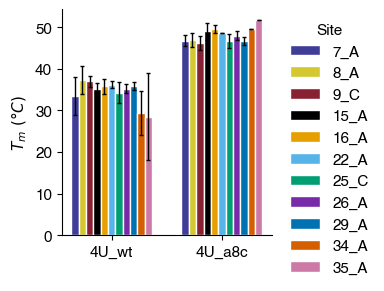

In [78]:
constructs = ['4U_wt', '4U_a8c']

# layout params
n_sites = max(len(to_fit[c]) for c in constructs)
group_width = 0.8                 # total width allotted to each construct block
bar_width = group_width / n_sites # width of each site bar within a block
x_centers = np.arange(len(constructs))

fig, ax = plt.subplots(figsize=(4, 3))

for c_idx, construct in enumerate(constructs):
    sites = to_fit[construct]
    sites = [s for s in to_fit[construct] if s != '18_A']
    # center the bars in this construct block
    offsets = (np.arange(len(sites)) - (len(sites) - 1) / 2) * bar_width

    for s_idx, site in enumerate(sites):
        row = tms_df[(tms_df['construct'] == construct) & (tms_df['site'] == site)]

        if row.empty:
            tm = np.nan
            err = np.nan
        else:
            tm = row['tm'].iloc[0]
            e = row['tm_err'].iloc[0]
            err = e if (pd.notna(e) and e <= 20) else np.nan

        ax.bar(
            x_centers[c_idx] + offsets[s_idx],
            tm,
            width=bar_width * 1,
            yerr=err,
            capsize=1.5,
            error_kw={
              'elinewidth': 1,   # thickness of the error bar line
                'capthick': 1     # thickness of the caps
            },
            color=site_palette.get(site, 'gray'),
            edgecolor='white',
            linewidth=1,
            label=site if (c_idx == 0) else None  # label only once for legend
        )

ax.set_xticks(x_centers)
ax.set_xticklabels(constructs)
ax.set_ylabel(r'$T_m\ (\degree C)$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend (sites from first construct only, avoids duplicates)
ax.legend(
    title='Site',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=False
)

plt.tight_layout()
plt.savefig('fitted_tm.pdf')
plt.show()

In [79]:
tms_df

,construct,site,tm,tm_err
0,4U_wt,7_A,33.435136,4.522344
1,4U_wt,8_A,37.247694,3.365114
2,4U_wt,9_C,36.986052,1.303665
3,4U_wt,15_A,35.201106,1.499750
4,4U_wt,16_A,35.783561,1.753447
5,4U_wt,22_A,36.216147,0.898242
6,4U_wt,25_C,34.292134,2.454541
7,4U_wt,26_A,35.263365,1.168271
8,4U_wt,29_A,35.871972,0.877362
9,4U_wt,34_A,29.389170,5.256895
